In [1]:
pip install numpy opencv-python-headless matplotlib scikit-learn tensorflow

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


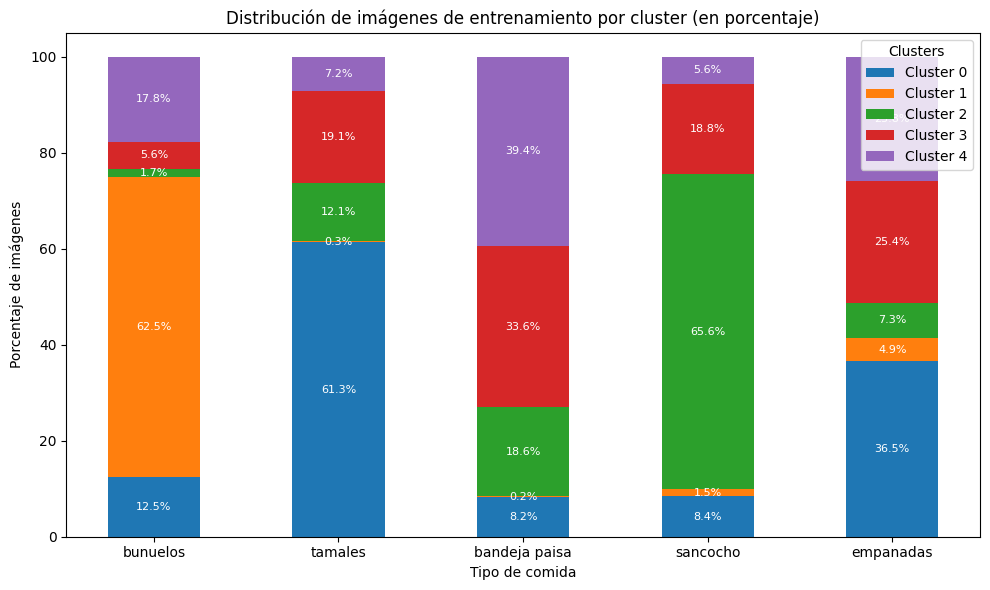

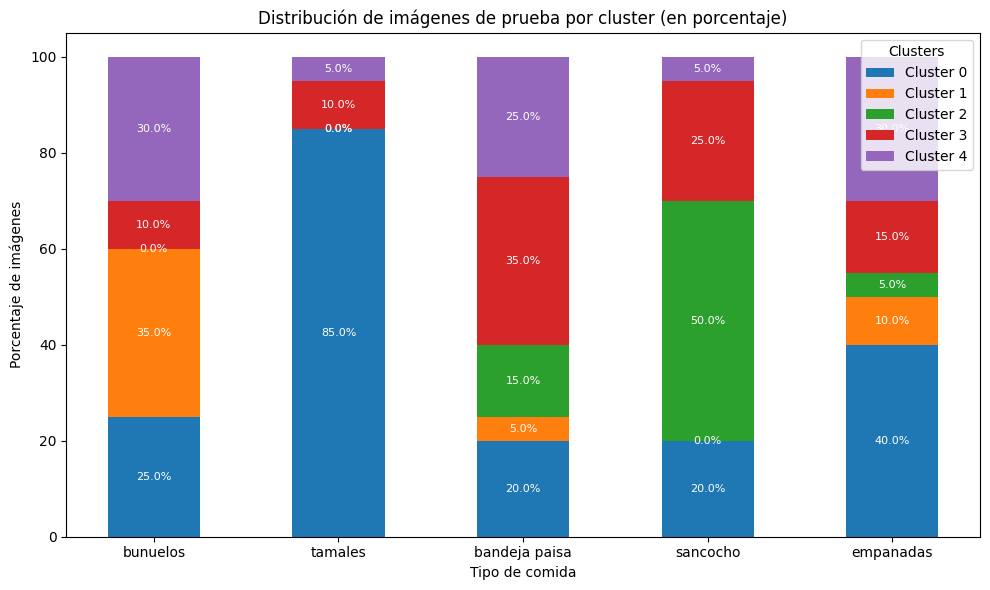

In [60]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Rutas de las carpetas de entrenamiento y prueba
ruta_entrenamiento = 'imagenes/entrenamiento'
ruta_prueba = 'imagenes/prueba'

# Cargar modelo preentrenado EfficientNetV2
modelo_efficientnet = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Función para cargar imágenes y extraer características usando EfficientNetV2
def cargar_imagenes_y_extraer_caracteristicas_vgg(ruta):
    caracteristicas = []
    etiquetas = []
    for carpeta in os.listdir(ruta):
        carpeta_completa = os.path.join(ruta, carpeta)
        if os.path.isdir(carpeta_completa):
            for archivo in os.listdir(carpeta_completa):
                ruta_imagen = os.path.join(carpeta_completa, archivo)
                imagen = cv2.imread(ruta_imagen)
                if imagen is not None:
                    # Cambiamos el tamaño de la imagen para normalizar
                    imagen = cv2.resize(imagen, (100, 100))
                    imagen = np.expand_dims(imagen, axis=0)
                    imagen = preprocess_input(imagen)
                    # Extraemos las características con EfficientNetV2
                    caracteristica = modelo_efficientnet.predict(imagen, verbose=0)
                    caracteristica = caracteristica.flatten()
                    caracteristicas.append(caracteristica)
                    etiquetas.append(carpeta)
    return np.array(caracteristicas), etiquetas

# Cargar imágenes de entrenamiento y extraer características usando EfficientNetV2
caracteristicas_entrenamiento, etiquetas_entrenamiento = cargar_imagenes_y_extraer_caracteristicas_vgg(ruta_entrenamiento)

# Aplicar K-means con k=5
numero_clusters = 5
kmeans = KMeans(n_clusters=numero_clusters, random_state=42)
kmeans.fit(caracteristicas_entrenamiento)

# Contar cuántas imágenes de cada tipo cayeron en cada cluster
conteo_clusters = {etiqueta: [0] * numero_clusters for etiqueta in set(etiquetas_entrenamiento)}

for i, etiqueta in enumerate(etiquetas_entrenamiento):
    cluster = kmeans.labels_[i]
    conteo_clusters[etiqueta][cluster] += 1

# Graficar resultados del entrenamiento
etiquetas = list(conteo_clusters.keys())
clusters = [f'Cluster {i}' for i in range(numero_clusters)]
datos = np.array([conteo_clusters[etiqueta] for etiqueta in etiquetas])
datos_pct = datos / datos.sum(axis=1, keepdims=True) * 100

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5
bottom = np.zeros(len(etiquetas))

for i in range(numero_clusters):
    ax.bar(etiquetas, datos_pct[:, i], bar_width, label=clusters[i], bottom=bottom)
    bottom += datos_pct[:, i]

for i, etiqueta in enumerate(etiquetas):
    for j in range(numero_clusters):
        y_pos = datos_pct[i, :j+1].sum() - datos_pct[i, j] / 2
        ax.text(i, y_pos, f'{datos_pct[i, j]:.1f}%', ha='center', va='center', fontsize=8, color='white')

ax.set_title('Distribución de imágenes de entrenamiento por cluster (en porcentaje)')
ax.set_xlabel('Tipo de comida')
ax.set_ylabel('Porcentaje de imágenes')
ax.legend(title='Clusters')
plt.tight_layout()
plt.show()

# Probar el modelo con nuevas imágenes
def probar_modelo(ruta, modelo):
    caracteristicas_prueba, etiquetas_prueba = cargar_imagenes_y_extraer_caracteristicas_vgg(ruta)
    predicciones = modelo.predict(caracteristicas_prueba)
    conteo_prueba = {etiqueta: [0] * modelo.n_clusters for etiqueta in set(etiquetas_prueba)}
    
    for i, etiqueta in enumerate(etiquetas_prueba):
        cluster = predicciones[i]
        conteo_prueba[etiqueta][cluster] += 1
    
    # Graficar resultados de la prueba
    etiquetas = list(conteo_prueba.keys())
    datos = np.array([conteo_prueba[etiqueta] for etiqueta in etiquetas])
    datos_pct = datos / datos.sum(axis=1, keepdims=True) * 100

    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = np.zeros(len(etiquetas))

    for i in range(modelo.n_clusters):
        ax.bar(etiquetas, datos_pct[:, i], bar_width, label=f'Cluster {i}', bottom=bottom)
        bottom += datos_pct[:, i]

    for i, etiqueta in enumerate(etiquetas):
        for j in range(modelo.n_clusters):
            y_pos = datos_pct[i, :j+1].sum() - datos_pct[i, j] / 2
            ax.text(i, y_pos, f'{datos_pct[i, j]:.1f}%', ha='center', va='center', fontsize=8, color='white')

    ax.set_title('Distribución de imágenes de prueba por cluster (en porcentaje)')
    ax.set_xlabel('Tipo de comida')
    ax.set_ylabel('Porcentaje de imágenes')
    ax.legend(title='Clusters')
    plt.tight_layout()
    plt.show()

# Probar con imágenes de la carpeta de prueba
probar_modelo(ruta_prueba, kmeans)